## Collect all fonts and apply filters

### Modules and pathes

In [1]:
import sys
sys.path.append('../')

In [2]:
# forcing the notebook to reload the modules
%load_ext autoreload
%autoreload 2

In [3]:
from src.data.global_consts import *
import matplotlib.pyplot as plt
from src.data import datacollector as dc
from src.data import downloader as dl
from src.data import datafilter as df
from src.data import classifier as cl
from src.data import datarenderer
from src.data import fontdb_handler as fh

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### Downloading the fonts

#### Fonts from github archives

In [62]:
# Download files from Databases
GOOGLEFONTSDB = True
DSRFONTSDB = True

dl.get_font_dbs({'GoogleFontsDB' : GOOGLEFONTSDB,
              'DSRFontsDB' : DSRFONTSDB})

Accessing GoogleFontsDB.
3 directories for transfer.
Transferring files...
File transfer successful
Accessing DSRFontsDB.
Loaded key for repository access.
4 directories for transfer.
Transferring files...
File transfer successful


#### Fonts from list(s) of URLs

In [6]:
# Process link lists, starting with glyphazzn
dl.update_glyphazzn_list()

# Start download. This will take a while! (approx 80 mins for glyphazzn)
dl.download_files_from_txts()

glyzphazzn link list updated.
glyphazzn_raw.txt successfully extracted.
Processing glyphazzn.txt...
Checking 66260 URLs...


### Processing all fonts

1. All zipped archives are getting unpacked. Through recursion, zip-in-zip are getting unpacked.
2. From data exploration we know that we will have fonts in different format: TTF, OTF and PFB.
3. We externally converted *.OFT to *.TTF. The converted files were copied into our private font database, hence our script will ignore *.OTF

To avoid copying files to a 'processed' folder, we will create a 00dataset.json file that we will use from now on. We will gradually fill the json with information.

In [5]:
dc.collectfonts()

Unpacking all zip files...
Total files: 61537
Fonts files: 50777
- TTF files: 40852
- OTF files: 9925
Usable files: 50777


## Filtering fonts

Finally, the filters are applied to the dataset. The filters will write a value to the json file for each font and set a general flag indicating whether the font is usable or not.

In [11]:
df.filter_fonts()

37it [00:00, 97.18it/s]'created' timestamp seems very low; regarding as unix timestamp
276it [00:02, 134.31it/s]'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
420it [00:03, 118.62it/s]'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
528it [00:04, 124.27it/s]'created' timestamp seems very low; regarding as unix timestamp
541it [00:04, 104.03it/s]'created' timestamp seems very low; regarding as unix timestamp
666it [00:05, 120.77it/s]'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
1259it [00:09, 158.15it/s]'created' timestamp seems very low; regarding as unix timestamp
1497it [00:11, 97.18it/s] 'created' timestamp out of rang

OverflowError: Python int too large to convert to C int


1611it [00:12, 136.30it/s]'created' timestamp out of range; ignoring top bytes
'modified' timestamp out of range; ignoring top bytes
'created' timestamp out of range; ignoring top bytes
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp out of range; ignoring top bytes
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
1626it [00:12, 115.60it/s]'created' timestamp seems very low; regarding as unix timestamp
1639it [00:13, 113.74it/s]'created' timestamp out of range; ignoring top bytes
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp out of range; ignoring top bytes
'modified' timestamp seems very low; regarding as unix timestamp
1676it [00:13, 149.45it/s]'created' timestamp out of range; ignoring top bytes
1760it [00:13, 133.56it/s]'created' timestamp seems very low; regarding as unix timestamp
1847it [00:14, 112.63it/s]'created' timestamp 

Processed 50777 fonts. Found 26198 usable fonts.


{'num_font_files_processed': 50777,
 'num_usable_fonts': 26198,
 'out_of_bounds': 10456,
 'has_empty_glyphs': 14394,
 'has_not_all_chars': 10710,
 'corrupted_file': 174}

Some fontsets have invalid glyps. We need to identify them and remove them from the dataset.
We are using CLIP to do so.

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Classification for File 1:
   letter ß: 0.7846
   letters ss: 0.0191
   an X: 0.0146
   one-colored box: 0.0001
   rectangle: 0.0004
   not letter ß: 0.1812
Classification for File 2:
   letter ß: 0.2441
   letters ss: 0.0750
   an X: 0.5567
   one-colored box: 0.0102
   rectangle: 0.0453
   not letter ß: 0.0687

Return classification dictionary: {'File 1': {'ß': True}, 'File 2': {'ß': False}}


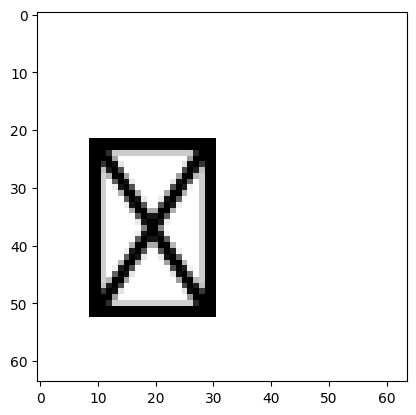

In [12]:
text_query = ['letter ß', 'letters ss', 'an X', 'one-colored box', 'rectangle', 'not letter ß']

img_arrays_test = datarenderer.render_fonts(['../data/raw/DSRFontsDB/DB1/fonts_otf/24Janvier-Light.otf', '../data/raw/DSRFontsDB/DB1/fonts_otf/AUSTRALIA-TITLE.otf'], chars='ß')
plt.imshow(img_arrays_test[1,:,:, 0], cmap='gray')
print(f"\nReturn classification dictionary: {cl.evaluate_image(['File 1', 'File 2'], img_arrays_test[:,:,:, 0], text_query, 'ß', verbose=True)}")

In [13]:
path_to_valid_fonts = fh.font_file_list()

print(path_to_valid_fonts[0:5])
print(type(path_to_valid_fonts))

['..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\24Janvier-Light.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\24Janvier.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\AgenorNeue-Regular.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Alido.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\allejo.otf']
<class 'list'>


In [21]:
fh.is_glyph_usable(path_to_valid_fonts[0], 'ß')

KeyError: '.'

In [8]:
import json

path_to_valid_fonts = fh.font_file_list()

text_query = ['letter ß', 'letters ss', 'an X', 'one-colored box', 'rectangle', 'not letter ß']

img_arrays = datarenderer.render_fonts(path_to_valid_fonts, chars='ß')
CLIP_result = cl.evaluate_image(path_to_valid_fonts, img_arrays[:100,:,:, 0], 'ß', text_query)


with open('clip.json', 'w', encoding='utf-8') as file:
    json.dump(CLIP_result, file, indent=4)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
  0%|          | 0/4 [00:26<?, ?it/s]


TypeError: unhashable type: 'list'